# Exploring Symbolic Attention

In [1]:
import torch
import torchinfo
from mechanistic_forward import symbolic_attn_forward_get_weights, block_forward_get_weights, datlm_forward_w_intermediate_results

import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import sys; sys.path.append('..')
from dual_attention_transformer import DualAttnTransformerLM
from language_models import TransformerLM

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def load_from_ckpt(ckpt_path):
    ckpt = torch.load(ckpt_path)
    model_config = ckpt['config']

    model_state_dict = ckpt['model']
    model_state_dict = {k.replace('_orig_mod.', ''): v for k, v in model_state_dict.items()}

    if 'n_heads_ra' in model_config:
        model = DualAttnTransformerLM(**model_config)
    else:
        model = TransformerLM(**model_config)

    model.load_state_dict(model_state_dict)

    return model

In [3]:
# model_path = '../log/DAT-ra8sa8nr32-ns512sh1-368M_2024_07_15_22_00_26/model_05000.pt'
# model_path = '../log/DAT-ra8sa8nr32-368M_2024_07_11_18_17_07/model_10000.pt'
# model_path = '../log/DAT-sa16ra16nr64-1.3B_2024_07_13_21_59_55/model_05000.pt'

# model_path = '../log/DAT-ra8sa8nr32-nonsharedSR_wt_tr-418M_2024_07_17_04_04_54/model_05000.pt'
model_path = '../log/DAT-ra8sa8nr32-mqa-nonsharedSR_wt_tr-374M_2024_07_17_03_17_18/model_05000.pt'

model_dat = load_from_ckpt(model_path).to('cuda')
model_dat = model_dat.eval()

In [4]:
torchinfo.summary(model_dat)
# torchinfo.summary(model_dat, input_data=torch.zeros((1, 1024), dtype=torch.int32).cuda(), device='cuda')

Layer (type:depth-idx)                                  Param #
DualAttnTransformerLM                                   --
├─ModuleDict: 1-1                                       --
│    └─Embedding: 2-1                                   51,511,296
│    └─Dropout: 2-2                                     --
│    └─ModuleList: 2-3                                  --
│    │    └─SymbolicAttention: 3-1                      3,146,752
│    │    └─SymbolicAttention: 3-2                      3,146,752
│    │    └─SymbolicAttention: 3-3                      3,146,752
│    │    └─SymbolicAttention: 3-4                      3,146,752
│    │    └─SymbolicAttention: 3-5                      3,146,752
│    │    └─SymbolicAttention: 3-6                      3,146,752
│    │    └─SymbolicAttention: 3-7                      3,146,752
│    │    └─SymbolicAttention: 3-8                      3,146,752
│    │    └─SymbolicAttention: 3-9                      3,146,752
│    │    └─SymbolicAttention: 3-10    

In [5]:
symbol_retriever = model_dat.layers.symbol_retrievers[0]
n_heads = symbol_retriever.n_heads
n_symbols = symbol_retriever.n_symbols
symbol_library = symbol_retriever.symbol_library.data
embedding_layer = model_dat.layers.token_embedder

In [6]:
vocab_size = 50257
embs = embedding_layer(torch.arange(vocab_size).to('cuda').unsqueeze(0))
symbs = symbol_retriever(embs)

symbs2, symbol_attn_weights = symbolic_attn_forward_get_weights(symbol_retriever, embs)

In [7]:
def compute_summary_stats_attn_weights(attn_weights, symbs):
    '''compute summary statistics of attention weights'''

    if type(attn_weights) == torch.Tensor:
        attn_weights = attn_weights.cpu().detach().numpy()

    attn_max_weight = attn_weights.max(axis=-1)
    attn_min_weight = attn_weights.min(axis=-1)
    attn_mean_weight = attn_weights.mean(axis=-1)

    attn_argmax = attn_weights.argmax(axis=-1)

    attn_entropy = -(attn_weights * np.log(attn_weights)).sum(axis=-1)
    unif_entropy = np.log(attn_weights.shape[-1])

    token_symbol_similarity = torch.matmul(symbs, symbs.transpose(1, 2))
    similarity_sample = token_symbol_similarity.flatten()[np.random.choice(token_symbol_similarity.numel(), 1000)].cpu().detach().numpy()

    symbol_similarity = torch.matmul(symbol_retriever.symbol_library, symbol_retriever.symbol_library.transpose(0, 1)).cpu().detach().numpy()

    attn_stats = dict(
        attn_max_weight=attn_max_weight,
        attn_min_weight=attn_min_weight,
        attn_mean_weight=attn_mean_weight,
        attn_entropy=attn_entropy,
        attn_argmax=attn_argmax,
        unif_entropy=unif_entropy,
        similarity_sample=similarity_sample,
        symbol_similarity=symbol_similarity
    )

    return attn_stats

def plot_symb_attn_stats(symb_attn_stats, n_heads, n_symbols):

    figs, axs = plt.subplots(nrows=n_heads, ncols=4, figsize=(20, 5 * n_heads))
    if np.shape(axs) == (4,):
        axs = axs.reshape(1, 4)

    for i in range(n_heads):
        sns.histplot(symb_attn_stats['attn_max_weight'][i], ax=axs[i, 0])
        axs[i, 0].axvline(1 / n_symbols, color='red', linestyle='--')
        axs[i, 0].set_title(f'Max Attention Weight (Head {i})')

        sns.histplot(symb_attn_stats['attn_argmax'][i], ax=axs[i, 1])
        axs[i, 1].set_title(f'Argmax Attention Weight (Head {i})')

        sns.histplot(symb_attn_stats['attn_entropy'][i], ax=axs[i, 2])
        axs[i, 2].axvline(symb_attn_stats['unif_entropy'], color='red', linestyle='--')
        axs[i, 2].set_title(f'Entropy of Attention Weights (Head {i})')

        sns.histplot(symb_attn_stats['similarity_sample'], ax=axs[i, 3])
        axs[i, 3].set_title(f'Similarity between Tokens (Head {i})')

    plt.tight_layout()
    plt.show()

## Layer 0: Symbol Assignment of Tokens

In [8]:
print(f'# of symbols: {n_symbols}')
print(f'# of symbolic attention heads: {n_heads}')
print(f'# of tokens: {vocab_size}')
print(f'd_model: {model_dat.d_model}')

# of symbols: 1024
# of symbolic attention heads: 4
# of tokens: 50257
d_model: 1024


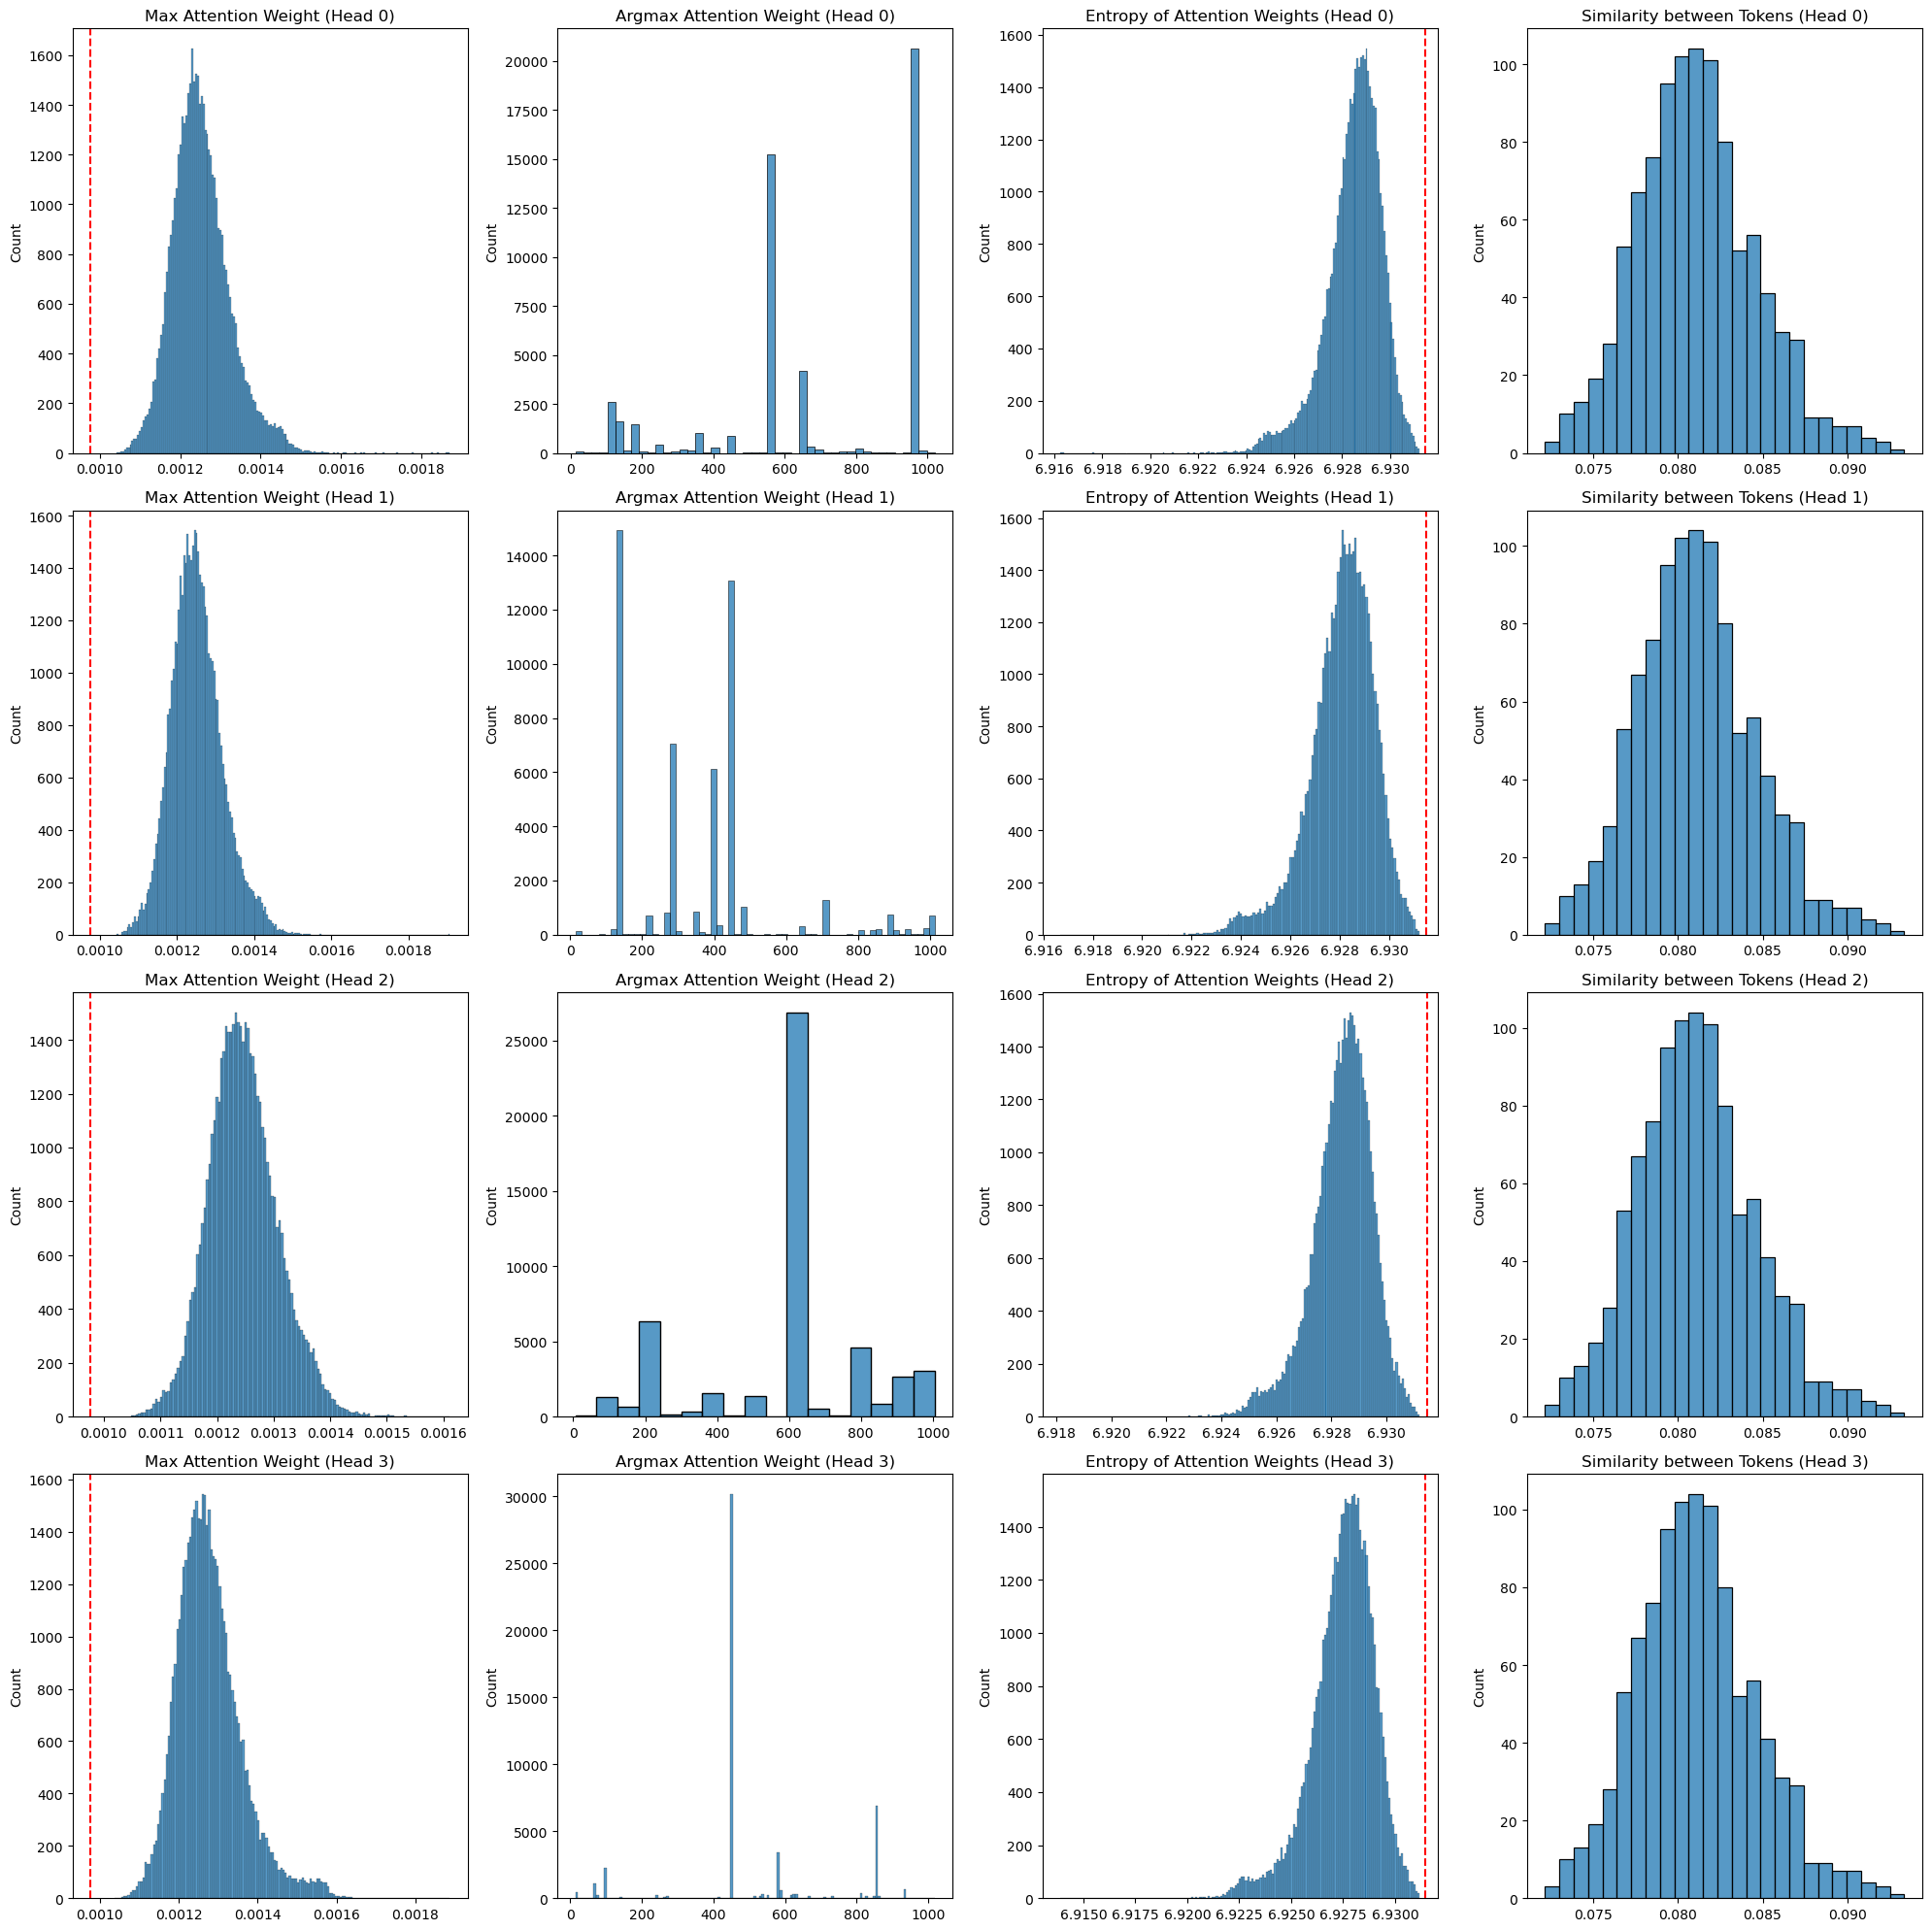

In [9]:
# layer 1 (independently process token)

symb_attn_stats = compute_summary_stats_attn_weights(symbol_attn_weights[0], symbs)

plot_symb_attn_stats(symb_attn_stats, n_heads=n_heads, n_symbols=n_symbols)

## Layerwise Visualization

In [10]:
import tiktoken

enc = tiktoken.get_encoding("gpt2")

In [11]:
string = """
A finite-state machine (FSM) or finite-state automaton (FSA, plural: automata), finite automaton, or simply a state machine, is a mathematical model of computation. It is an abstract machine that can be in exactly one of a finite number of states at any given time. The FSM can change from one state to another in response to some inputs; the change from one state to another is called a transition. An FSM is defined by a list of its states, its initial state, and the inputs that trigger each transition. Finite-state machines are of two types—deterministic finite-state machines and non-deterministic finite-state machines. For any non-deterministic finite-state machine, an equivalent deterministic one can be constructed.

The behavior of state machines can be observed in many devices in modern society that perform a predetermined sequence of actions depending on a sequence of events with which they are presented. Simple examples are: vending machines, which dispense products when the proper combination of coins is deposited; elevators, whose sequence of stops is determined by the floors requested by riders; traffic lights, which change sequence when cars are waiting; combination locks, which require the input of a sequence of numbers in the proper order.

The finite-state machine has less computational power than some other models of computation such as the Turing machine. The computational power distinction means there are computational tasks that a Turing machine can do but an FSM cannot. This is because an FSM's memory is limited by the number of states it has. A finite-state machine has the same computational power as a Turing machine that is restricted such that its head may only perform "read" operations, and always has to move from left to right. FSMs are studied in the more general field of automata theory.
"""

tokens = torch.tensor(enc.encode(string)).unsqueeze(0).to('cuda')
tokens.shape

torch.Size([1, 380])

In [12]:
# test_input = torch.arange(0, 512).cuda().unsqueeze(0)
logits, intermediate_results = datlm_forward_w_intermediate_results(model_dat, tokens)
print((model_dat(tokens)[0] - logits).abs().max()) # check that datlm_forward_w_intermediate_results produces the same result as model_dat


tensor(2.6703e-05, device='cuda:0', grad_fn=<MaxBackward1>)


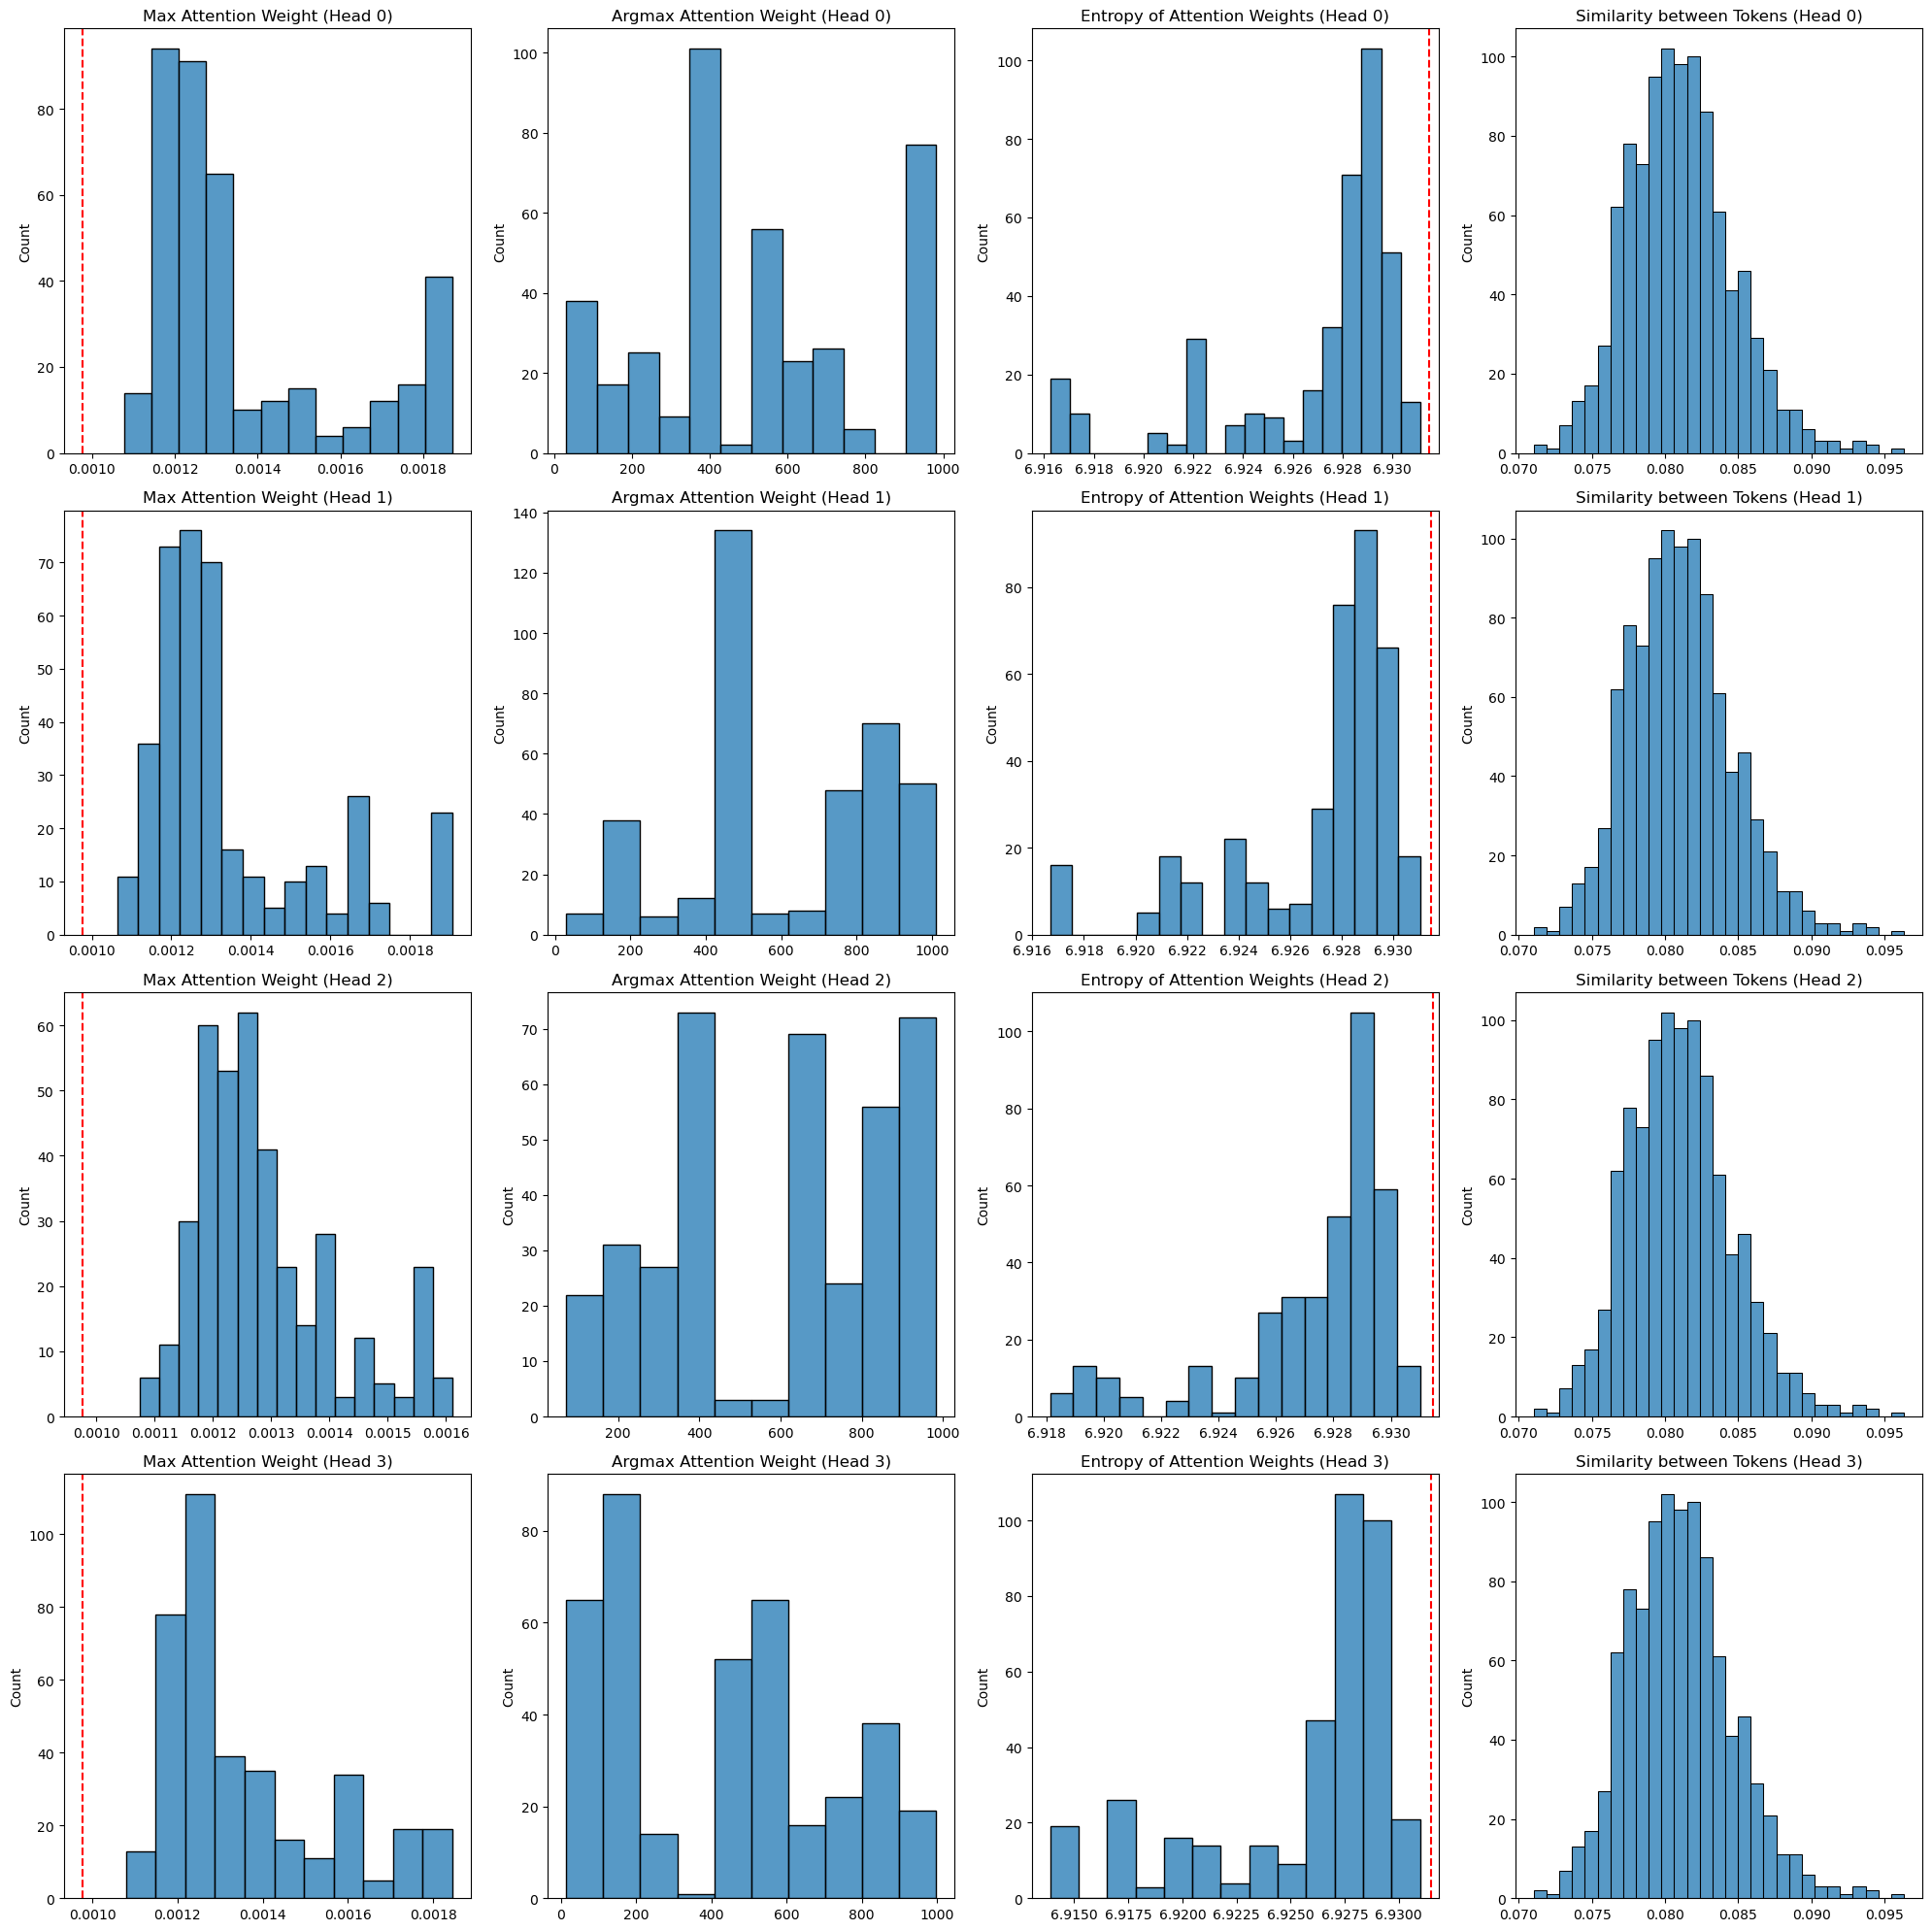

In [13]:
# layer 1
symb_attn_stats = compute_summary_stats_attn_weights(intermediate_results['symbol_attn_scores'][0][0], symbs)

plot_symb_attn_stats(symb_attn_stats, n_heads=n_heads, n_symbols=n_symbols)

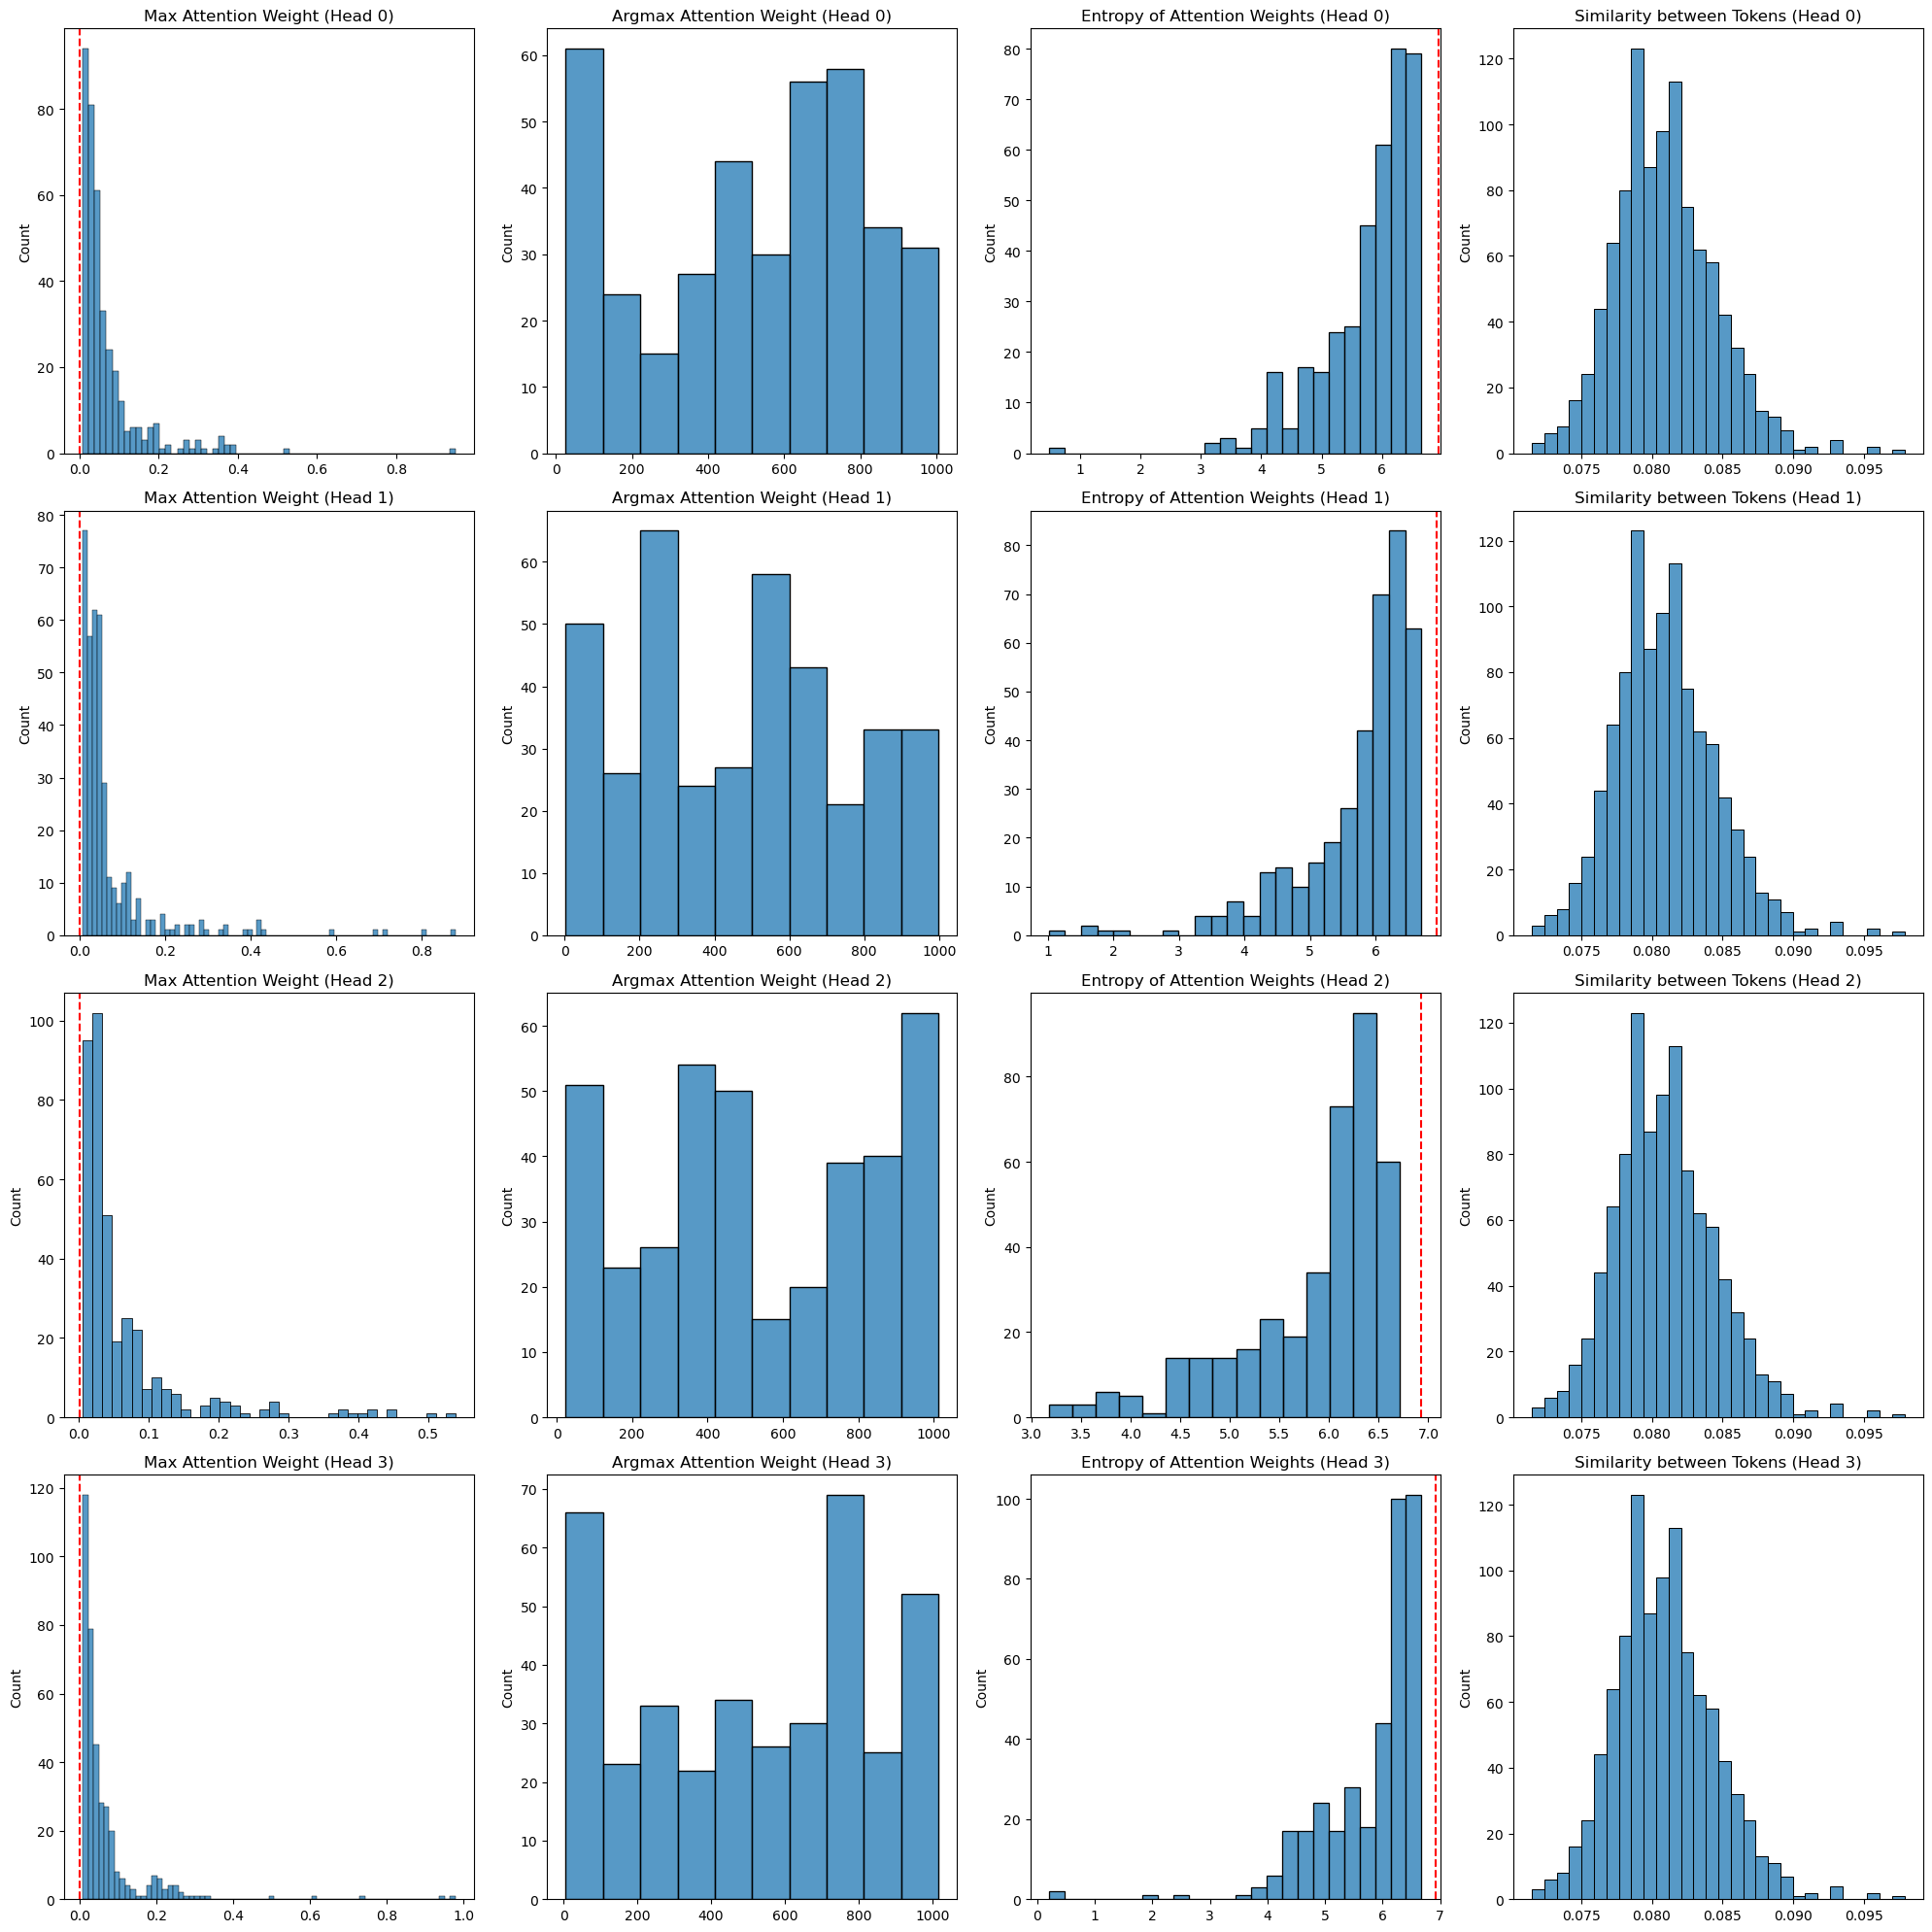

In [14]:
# layer 2
symb_attn_stats = compute_summary_stats_attn_weights(intermediate_results['symbol_attn_scores'][1][0], symbs)

plot_symb_attn_stats(symb_attn_stats, n_heads=n_heads, n_symbols=n_symbols)

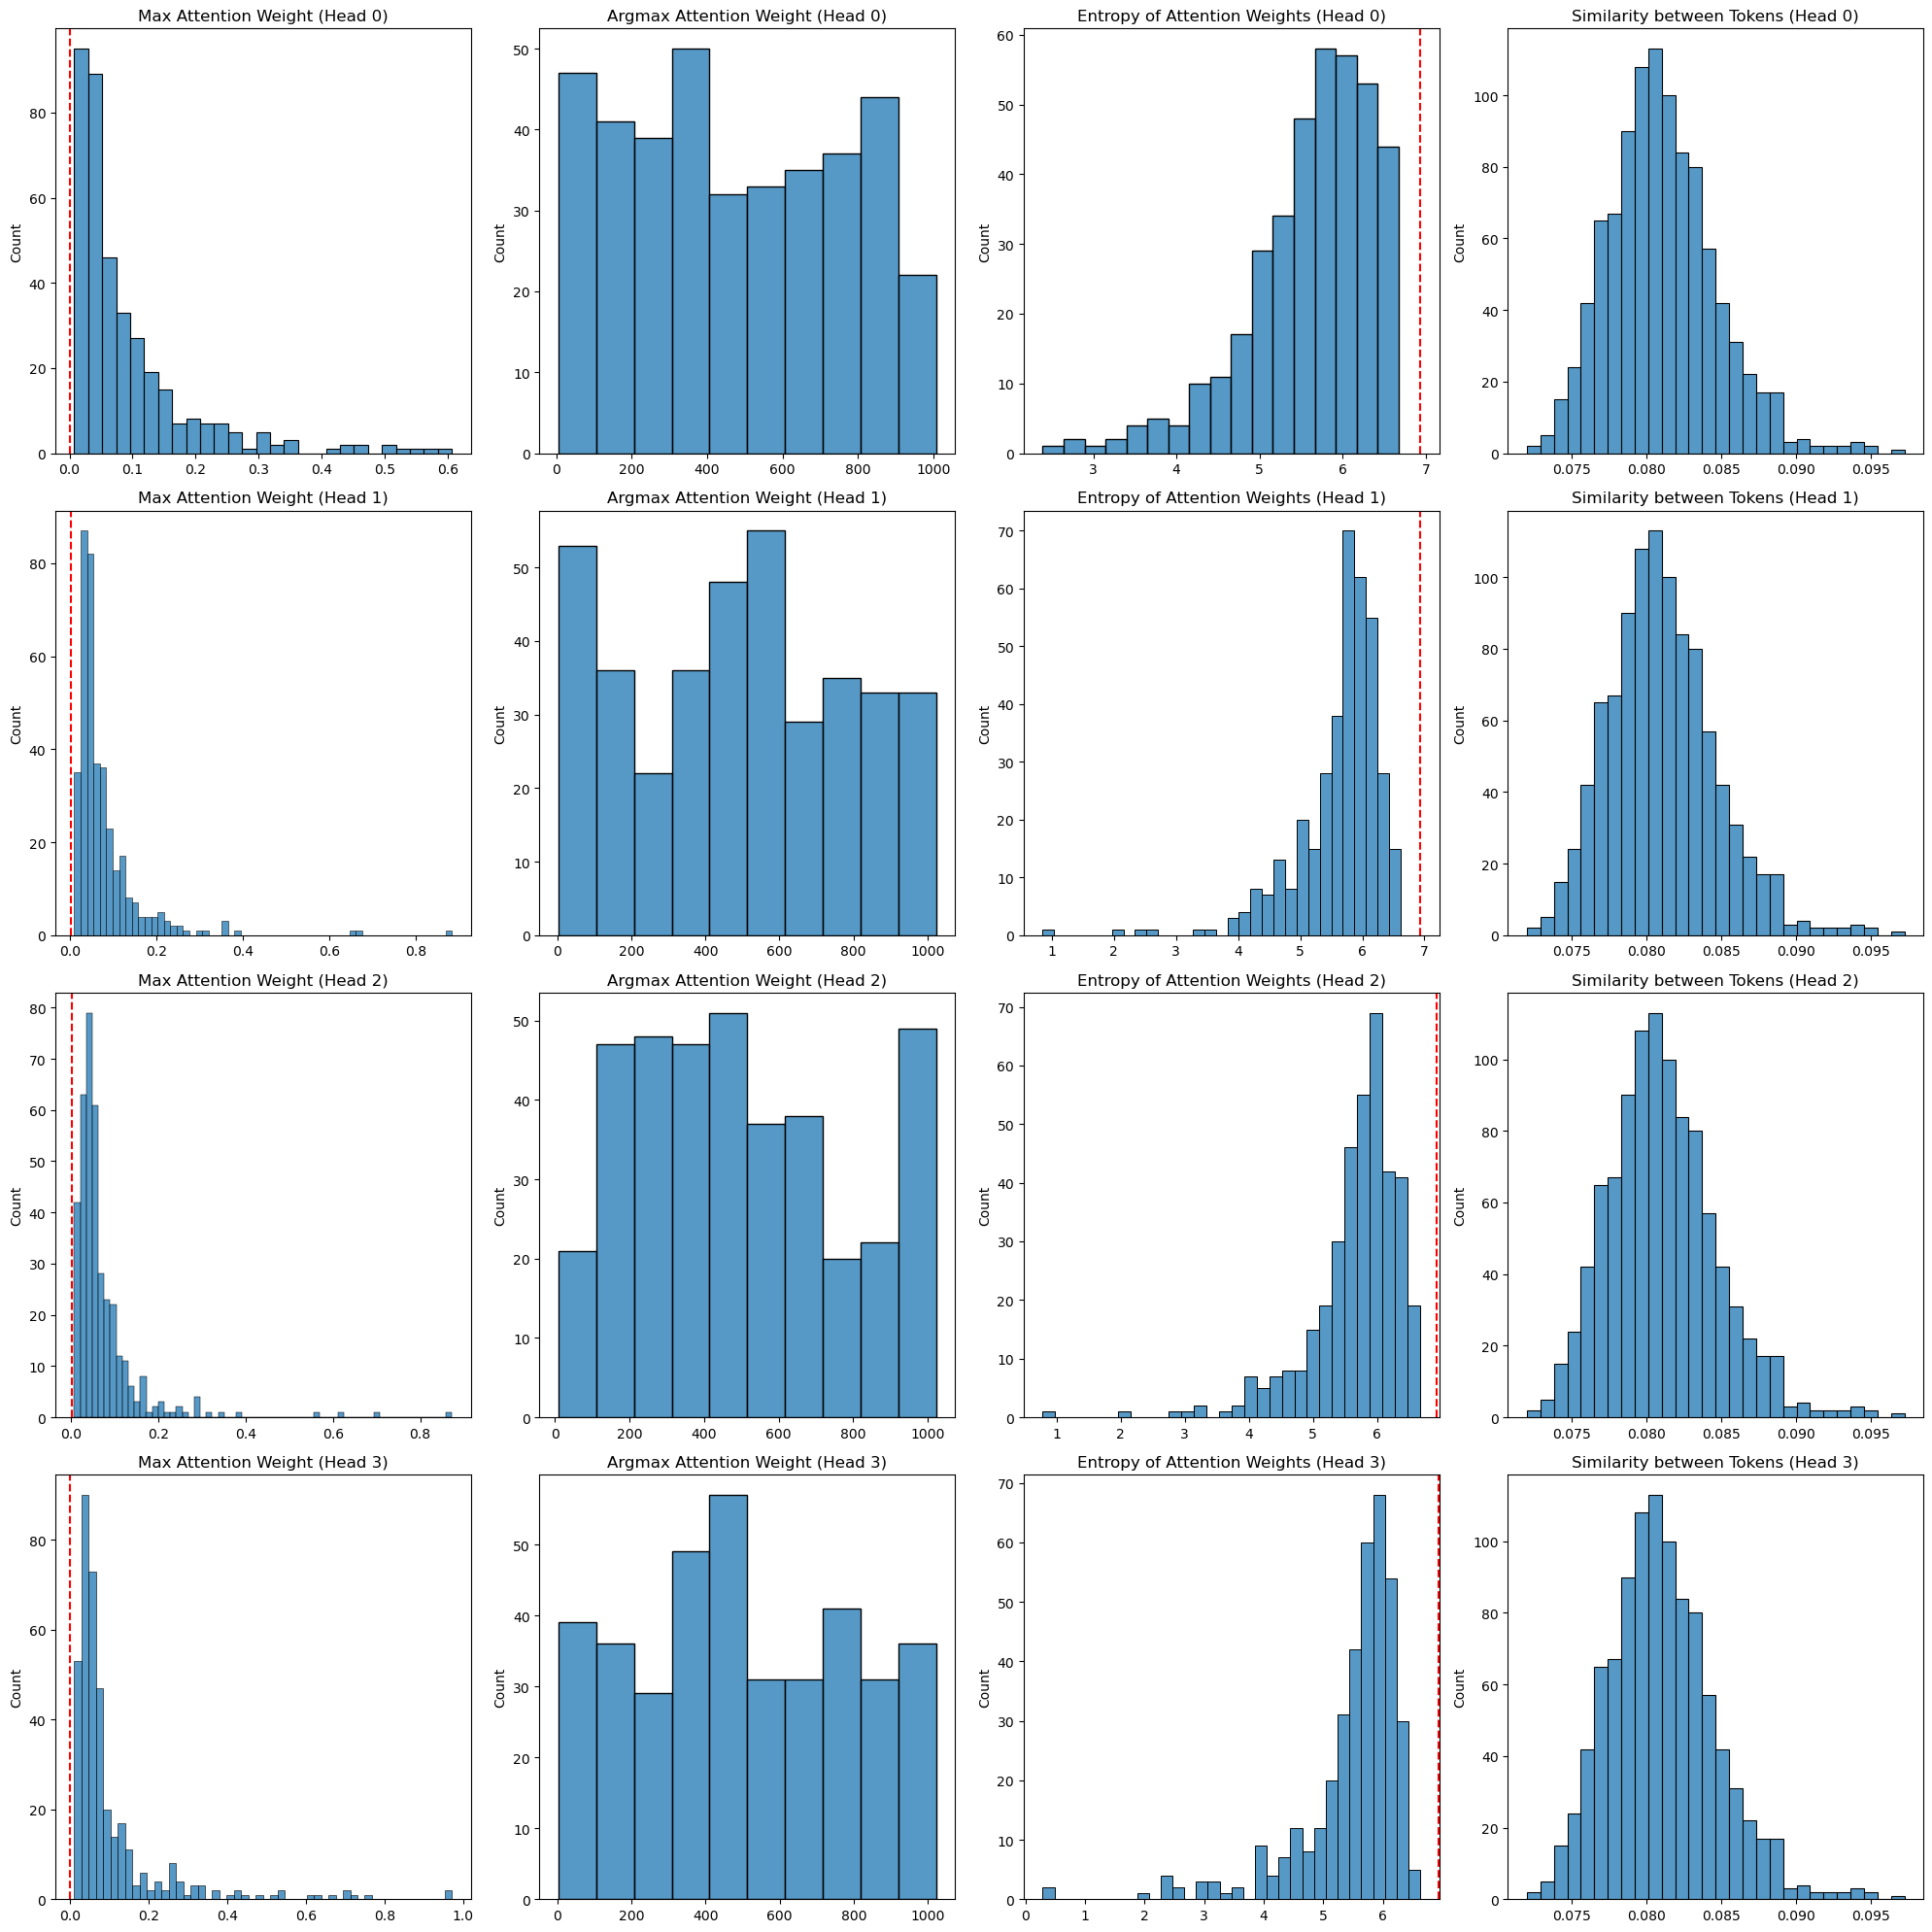

In [15]:
# layer 3
symb_attn_stats = compute_summary_stats_attn_weights(intermediate_results['symbol_attn_scores'][2][0], symbs)

plot_symb_attn_stats(symb_attn_stats, n_heads=n_heads, n_symbols=n_symbols)

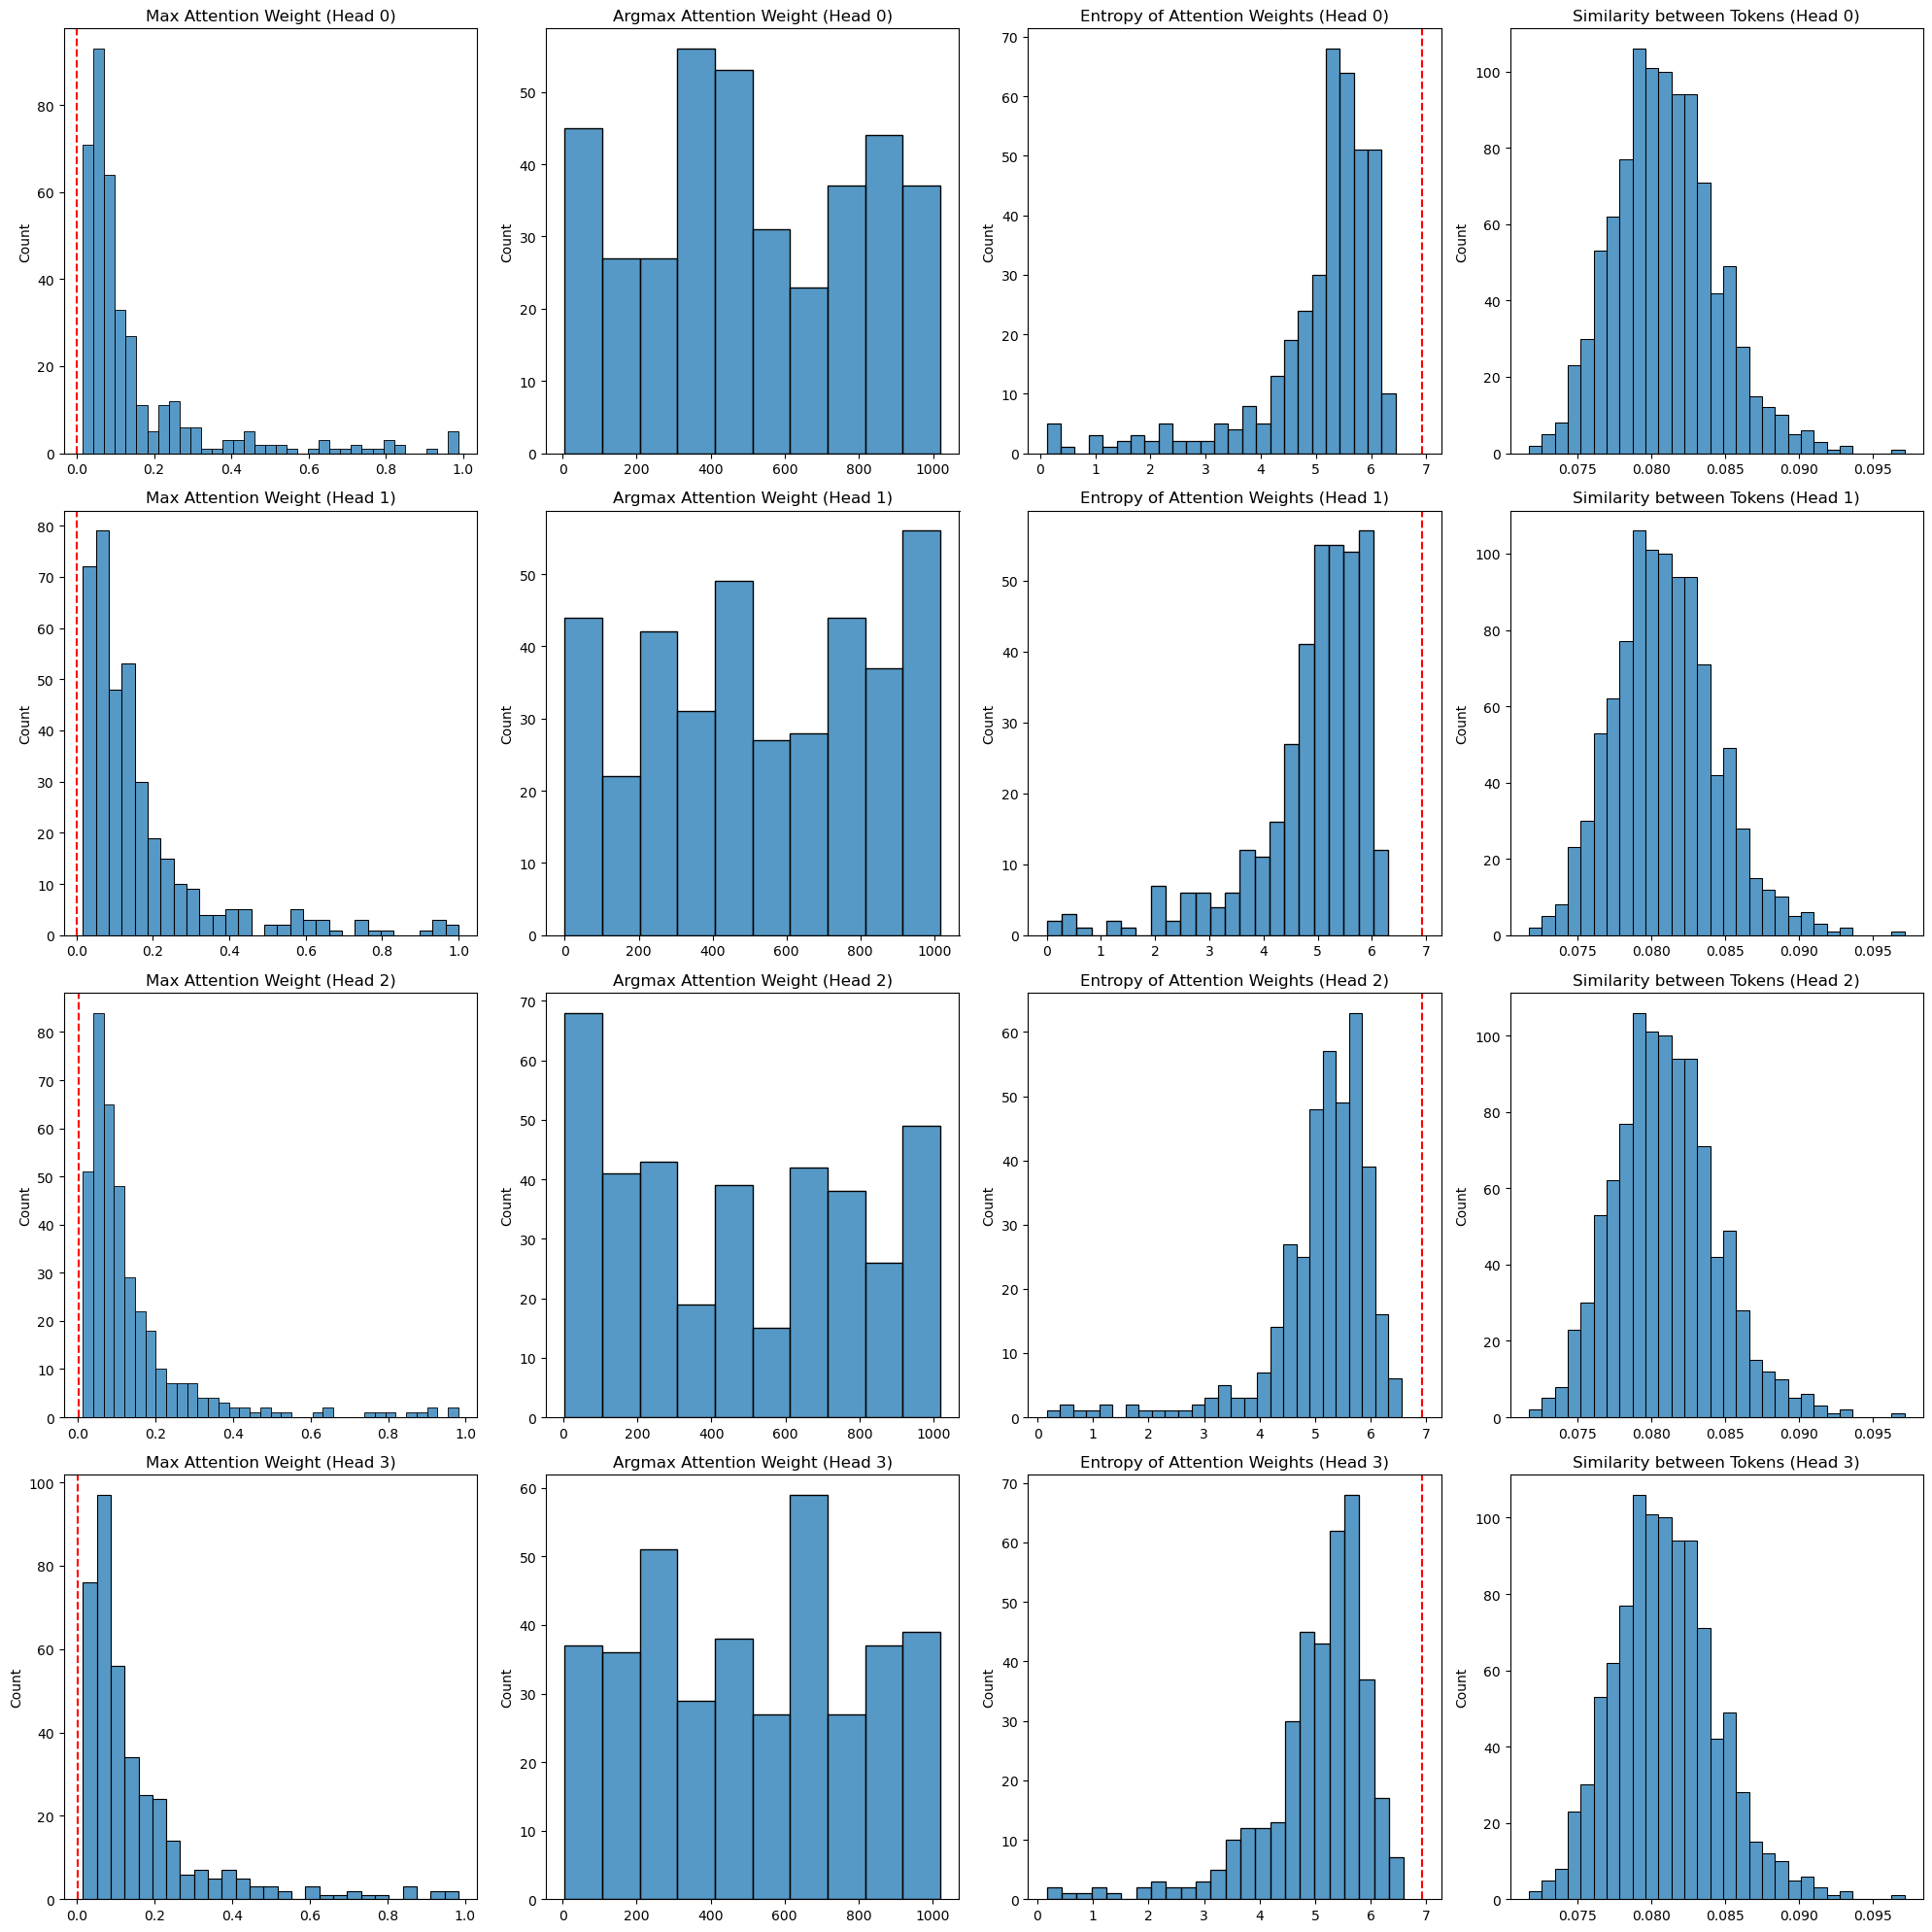

In [16]:
# layer 4
symb_attn_stats = compute_summary_stats_attn_weights(intermediate_results['symbol_attn_scores'][3][0], symbs)

plot_symb_attn_stats(symb_attn_stats, n_heads=n_heads, n_symbols=n_symbols)

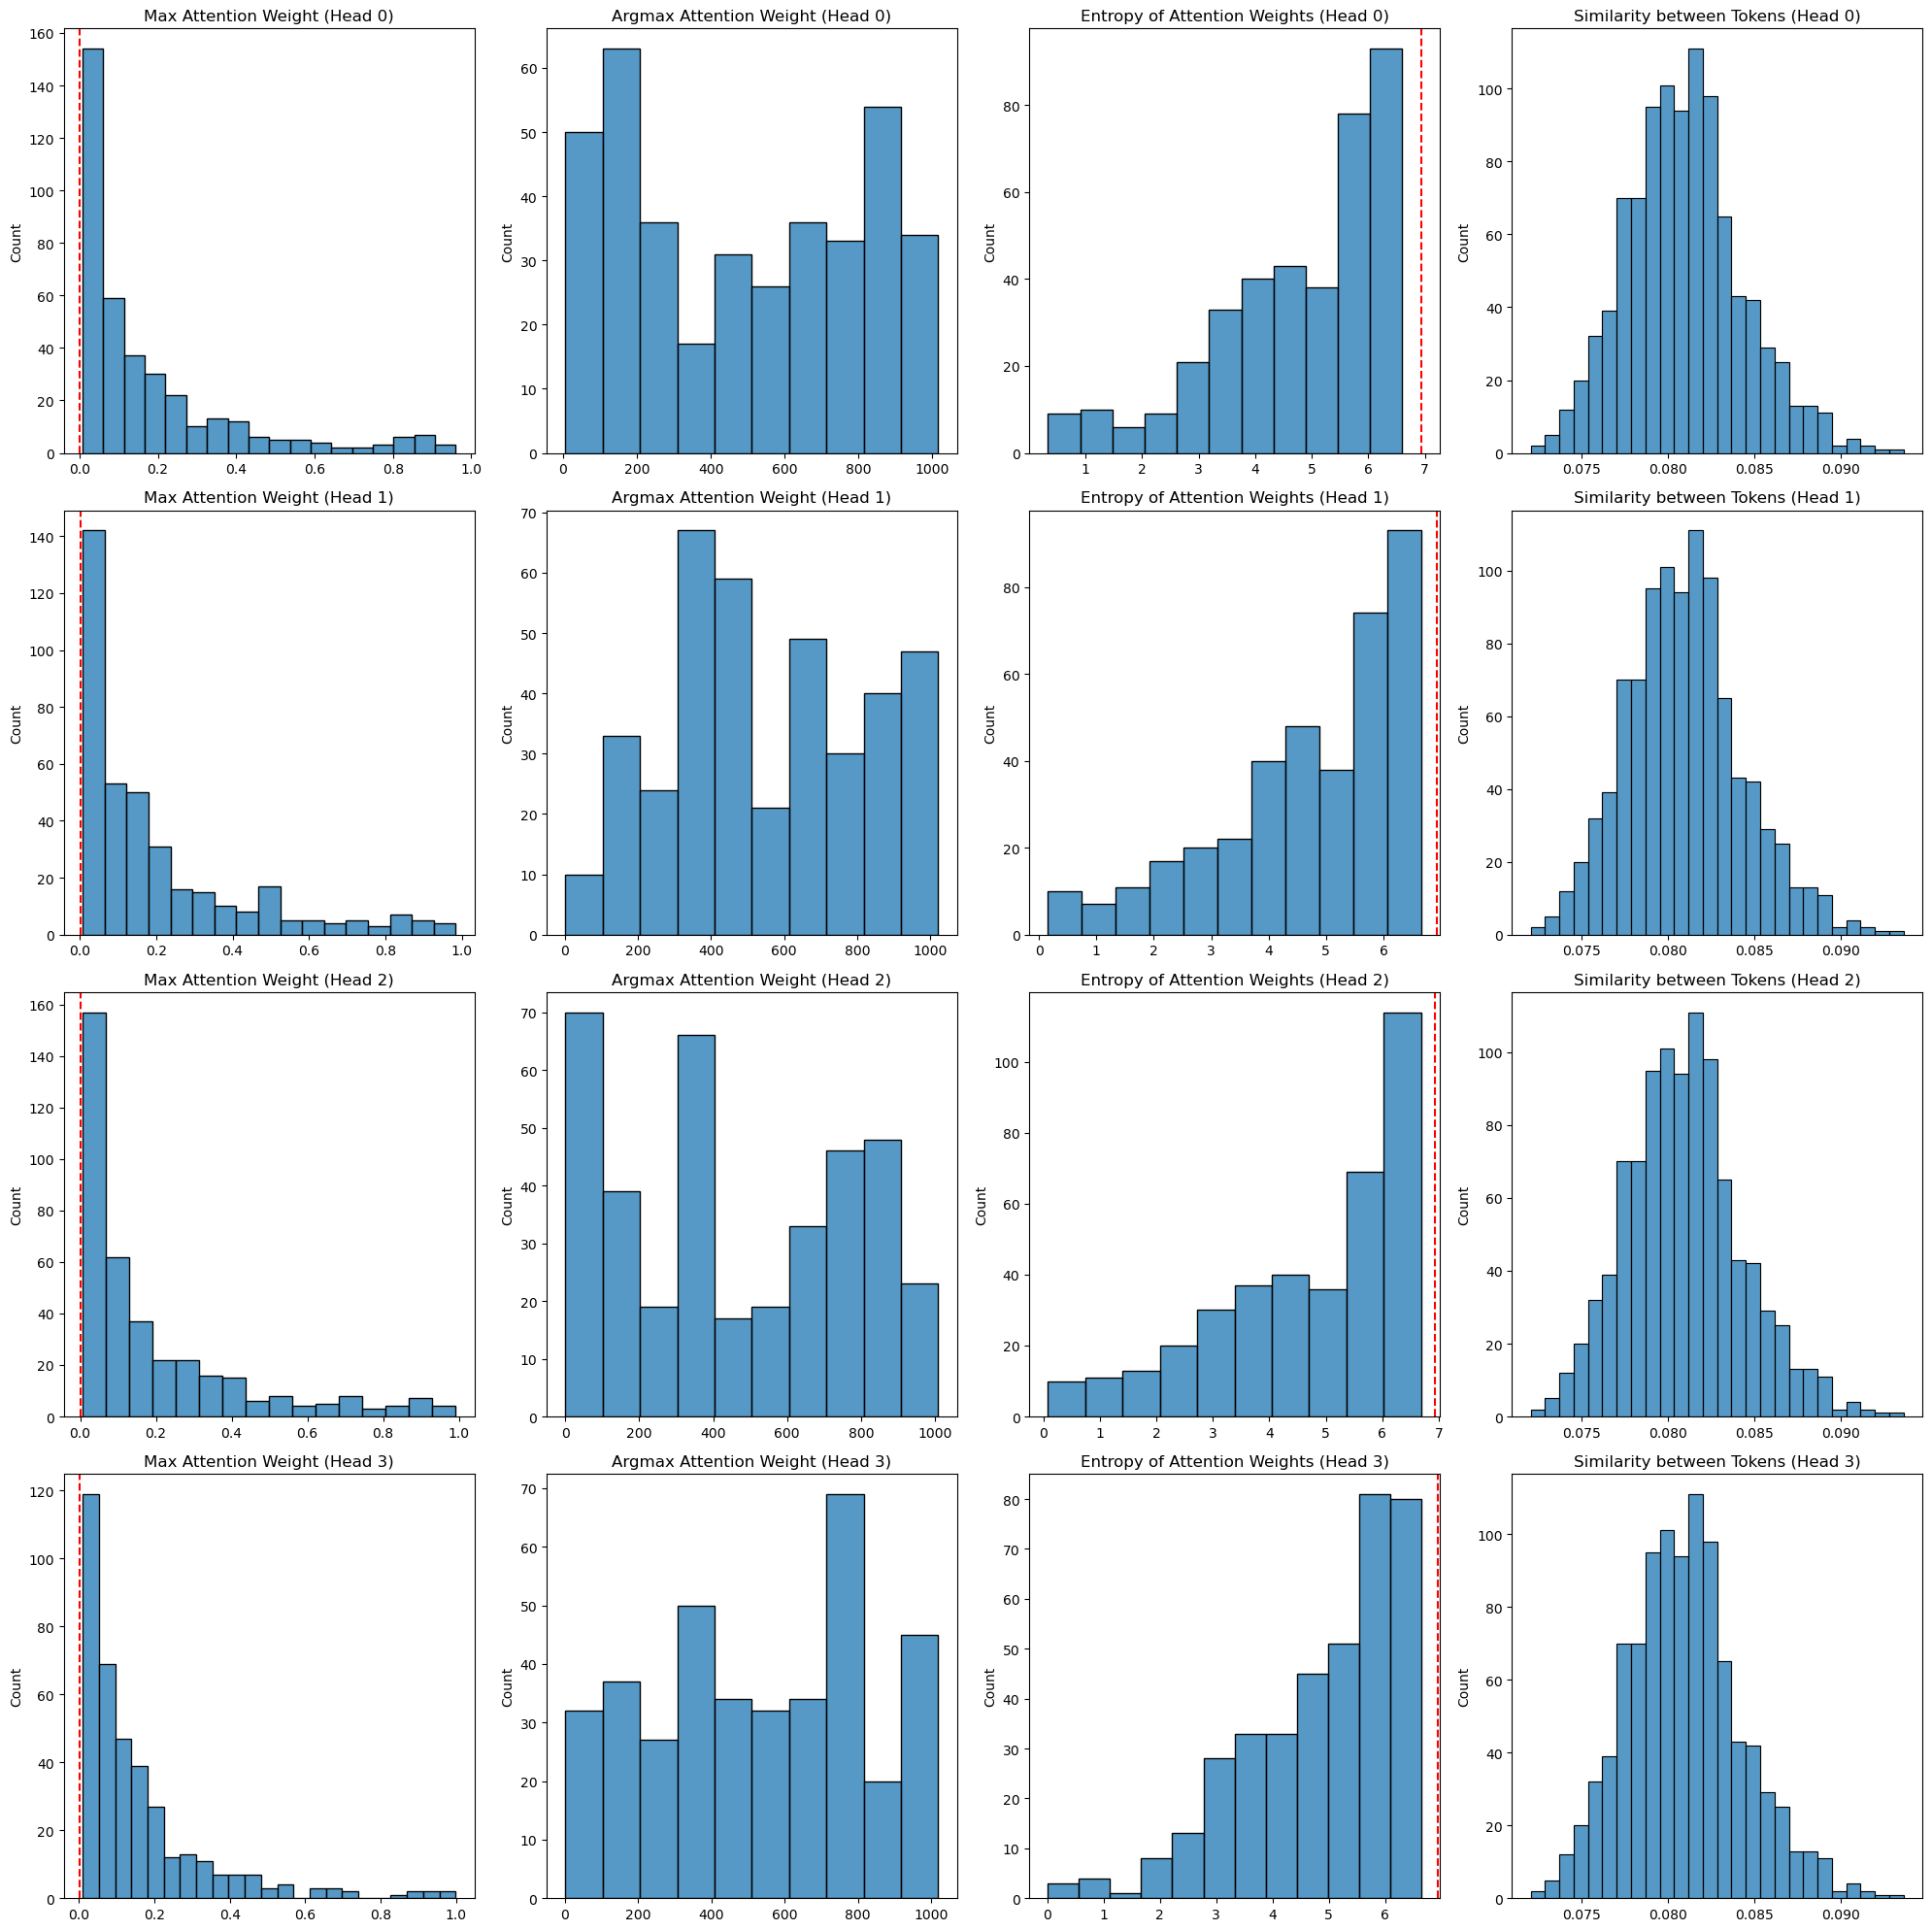

In [17]:
# layer 5
symb_attn_stats = compute_summary_stats_attn_weights(intermediate_results['symbol_attn_scores'][4][0], symbs)

plot_symb_attn_stats(symb_attn_stats, n_heads=n_heads, n_symbols=n_symbols)

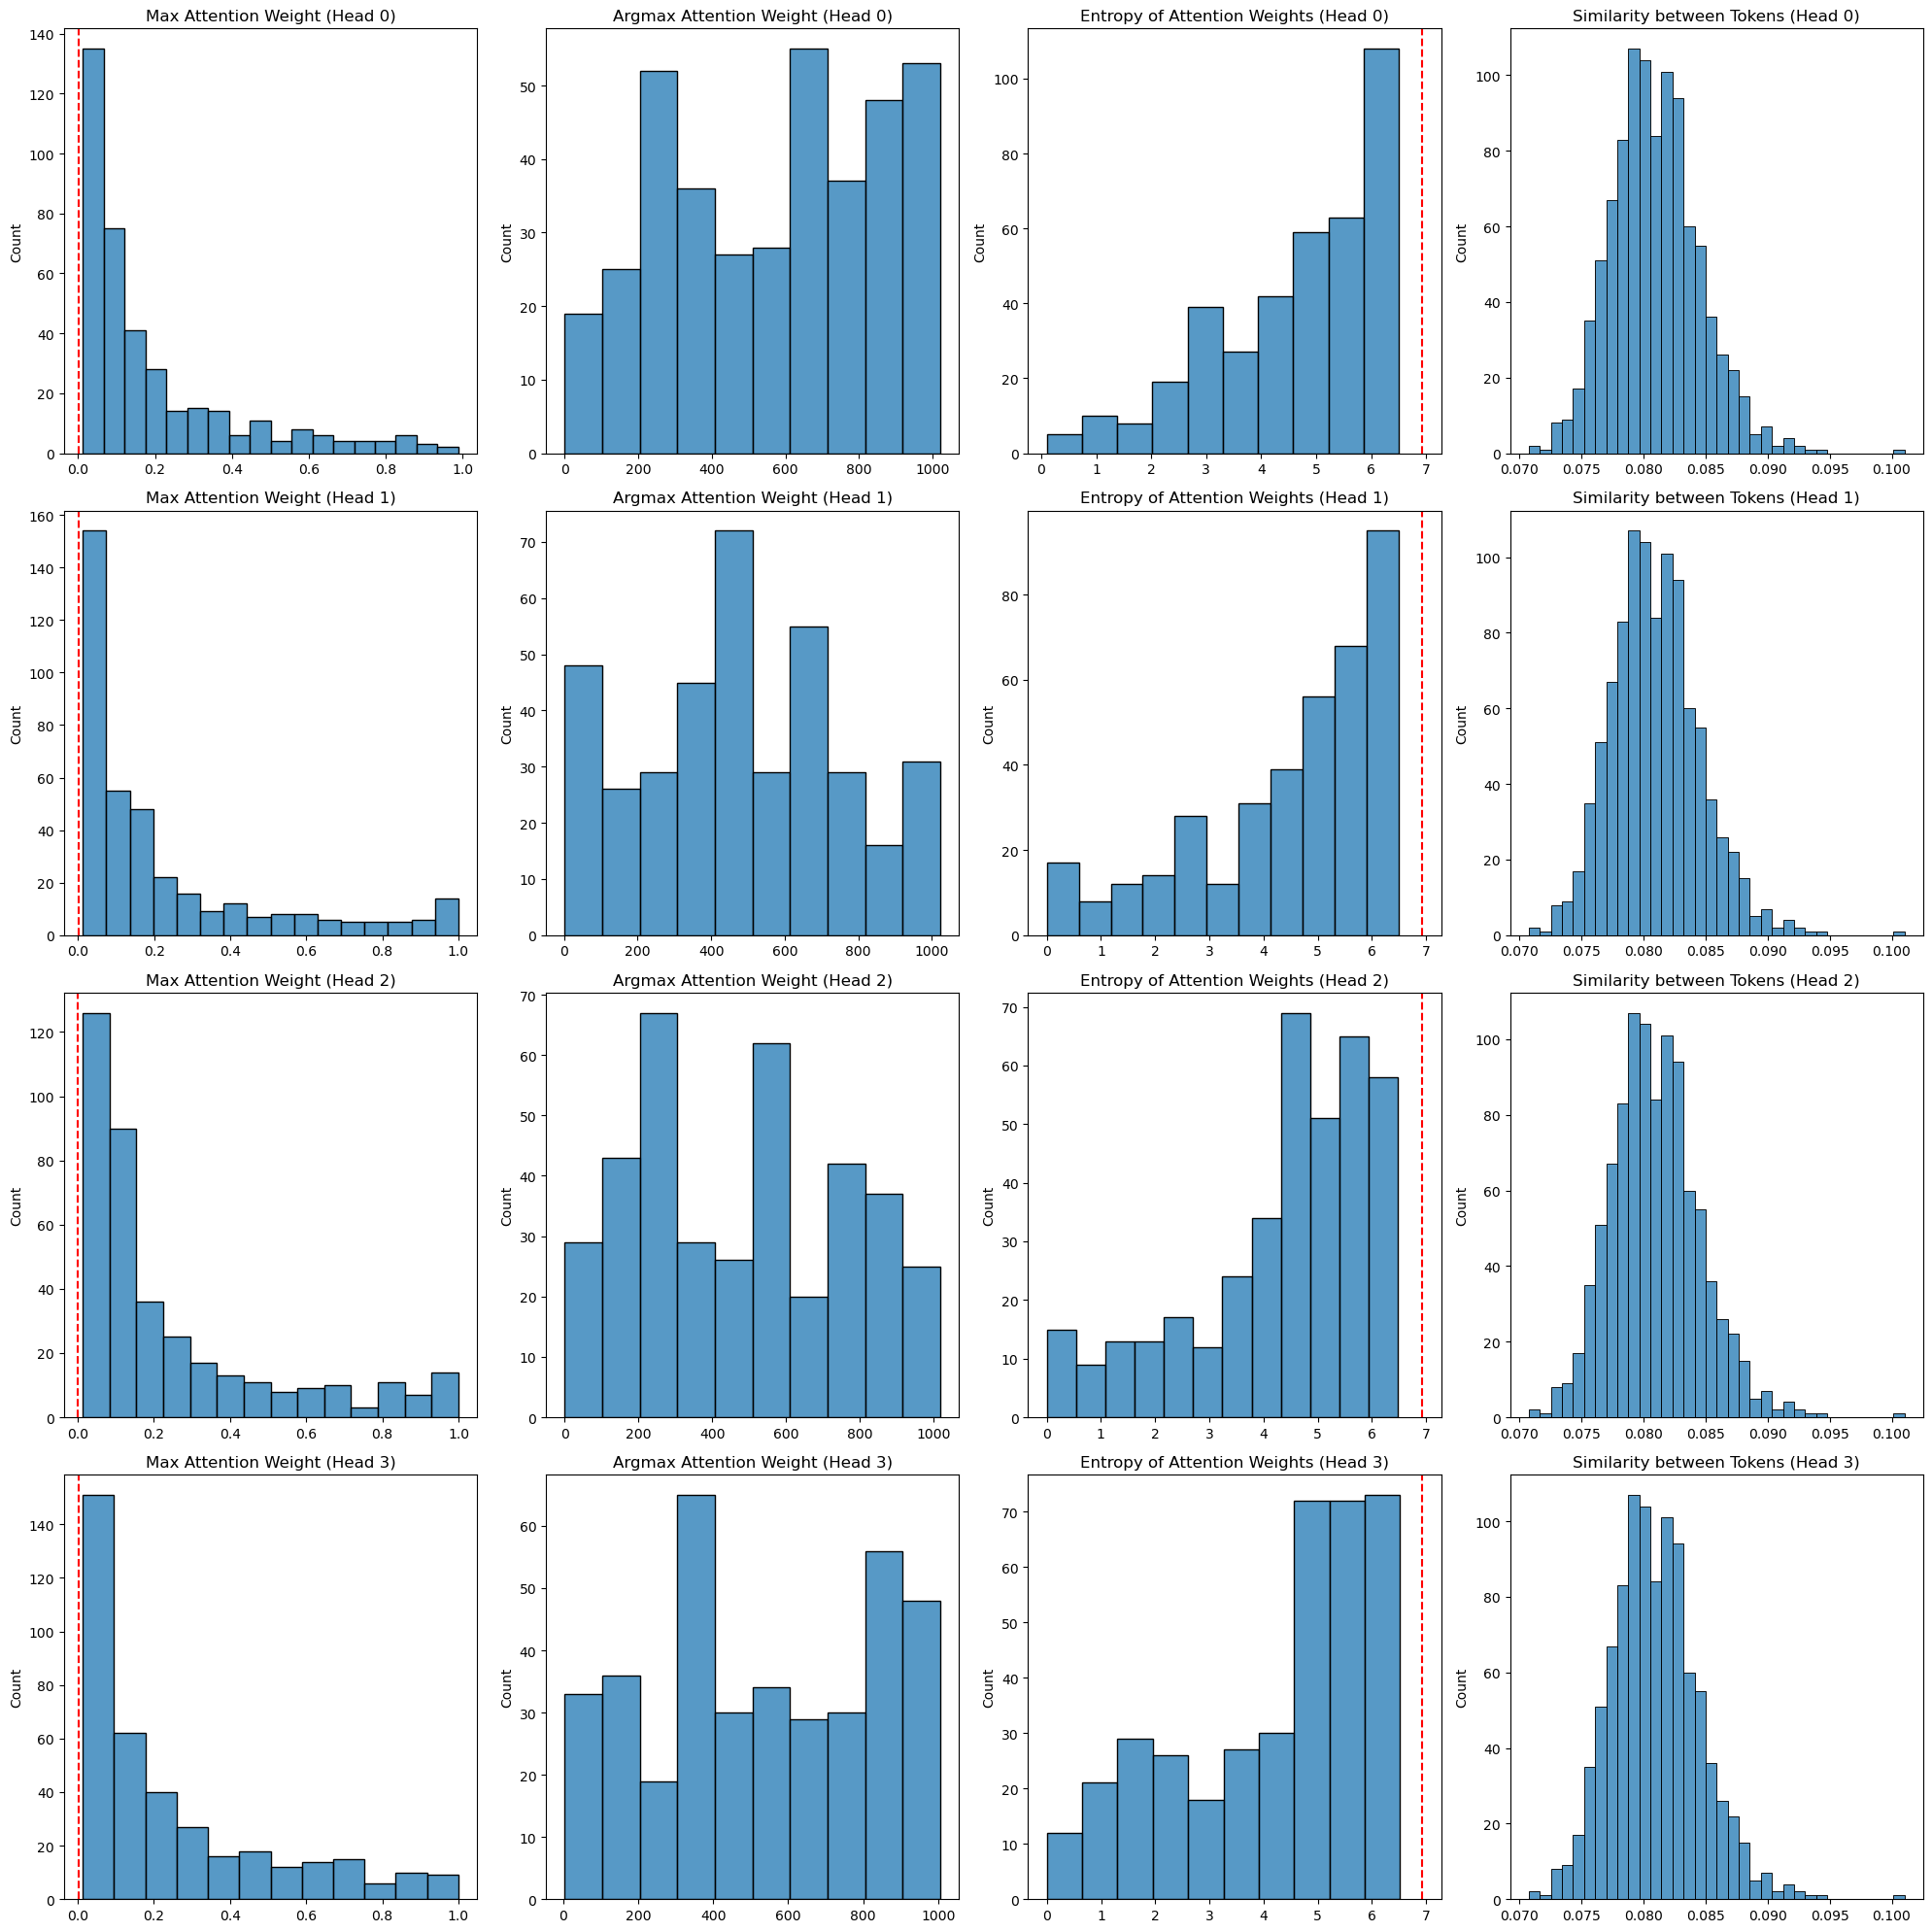

In [18]:
# layer 6
symb_attn_stats = compute_summary_stats_attn_weights(intermediate_results['symbol_attn_scores'][5][0], symbs)

plot_symb_attn_stats(symb_attn_stats, n_heads=n_heads, n_symbols=n_symbols)

## Summary Statistic of Symbolic Attention Across Layers

/tmp/ipykernel_3214031/3430343060.py:13: RuntimeWarning: divide by zero encountered in log
  attn_entropy = -(attn_weights * np.log(attn_weights)).sum(axis=-1)
/tmp/ipykernel_3214031/3430343060.py:13: RuntimeWarning: invalid value encountered in multiply
  attn_entropy = -(attn_weights * np.log(attn_weights)).sum(axis=-1)


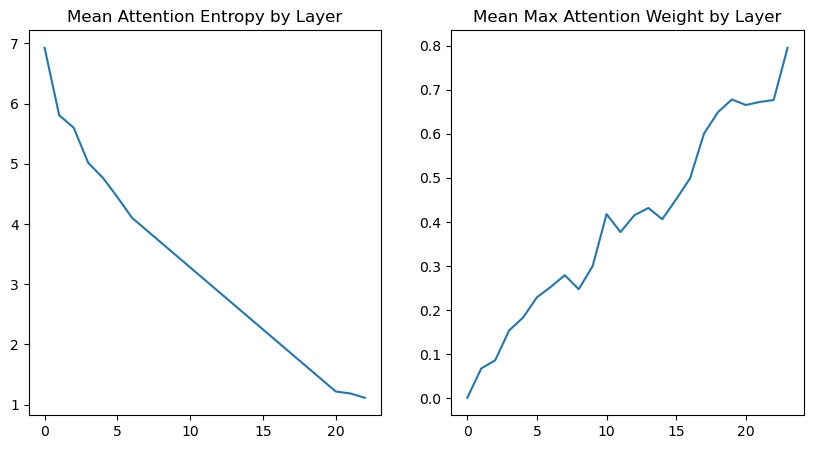

In [19]:
entropy_by_layer = []
max_attn_by_layer = []
for l in range(model_dat.n_layers):
    symb_attn_stats = compute_summary_stats_attn_weights(intermediate_results['symbol_attn_scores'][l][0], symbs)
    entropy_by_layer.append(symb_attn_stats['attn_entropy'].mean())
    max_attn_by_layer.append(symb_attn_stats['attn_max_weight'].mean())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=np.arange(model_dat.n_layers), y=entropy_by_layer, ax=ax1)
ax1.set_title('Mean Attention Entropy by Layer');

sns.lineplot(x=np.arange(model_dat.n_layers), y=max_attn_by_layer, ax=ax2)
ax2.set_title('Mean Max Attention Weight by Layer');

In [20]:
# get sample of tokens assigned to each symbol
symbol_attn_scores = intermediate_results['symbol_attn_scores']

In [21]:
layer = 0
symbol_attn_scores = intermediate_results['symbol_attn_scores'][layer][0].cpu().detach().numpy()

for head in range(n_heads):
    print('='*20 + f' Head {head} ' + '='*20)
    symbol_assignment = list(zip(symbol_attn_scores.argmax(axis=-1)[head], tokens[0].cpu().numpy()))
    symbol_assignment_dict = {s: [] for s in range(n_symbols)}
    for s, t in symbol_assignment:
        # print(f'{enc.decode([t])} -> {s}')
        symbol_assignment_dict[s].append(enc.decode([t]))

    for k,v in symbol_assignment_dict.items():
        if len(v) > 0:
            print(f'{k} -> {set(v)}')
    print('='*50)
    print()

==================== Head 0 ====================
31 -> {'.'}
32 -> {'\n', ' For', ' An', ';', ' The', ' A'}
101 -> {' only', ' another', ' one', ' more'}
110 -> {' Fin', ' vending'}
111 -> {'"', '—', ' (', ':', '),'}
133 -> {' "'}
142 -> {' require', ' perform', ' studied', ' disp'}
170 -> {' some', ' they'}
185 -> {' depending'}
247 -> {' devices', 'read', ' products', 'M', ' numbers'}
255 -> {' do', ' be', ' is', ' given', ' are'}
308 -> {' Turing'}
335 -> {' may', ' can'}
386 -> {' whose'}
395 -> {' cannot'}
412 -> {' a', ' or', ' such', "'s", ' in', ',', ' as', ' an', ' the', ' on', ' at', ' and', ' it', '-', ' with', ' called', ' by', ' to', ' from', ' than', ' of', ' when', 'd'}
444 -> {' right'}
448 -> {' elev'}
543 -> {' F'}
548 -> {' which', ' that', ' but'}
559 -> {' waiting', ' memory', ' autom', ' head', ' presented', ' deposited', 'ite', ' locks', ' lights', 'eter', ' machines', ' less', 'ense', 'ata', ' floors', 'ators', ' traffic', 'Ms', 'state', ' change', ' stops', ' l

In [22]:
layer = 4
symbol_attn_scores = intermediate_results['symbol_attn_scores'][layer][0].cpu().detach().numpy()

for head in range(n_heads):
    print('='*20 + f' Head {head} ' + '='*20)
    symbol_assignment = list(zip(symbol_attn_scores.argmax(axis=-1)[head], tokens[0].cpu().numpy()))
    symbol_assignment_dict = {s: [] for s in range(n_symbols)}
    for s, t in symbol_assignment:
        # print(f'{enc.decode([t])} -> {s}')
        symbol_assignment_dict[s].append(enc.decode([t]))

    for k,v in symbol_assignment_dict.items():
        if len(v) > 0:
            print(f'{k} -> {set(v)}')
    print('='*50)
    print()

==================== Head 0 ====================
6 -> {' be', ' its', ' same', ' equivalent', ' whose', ' has', ' trigger', ' change', ' when', ' operations'}
8 -> {' number'}
13 -> {' Fin'}
28 -> {' its', ' initial', 'eter', ' the', 'd'}
31 -> {' number', ' of', ' deposited', ' change', ' only'}
33 -> {' ('}
51 -> {' models'}
52 -> {' each'}
53 -> {' a'}
82 -> {'\n', ' is', ' the', ' in', ' and', ',', ' some', ' many', ' are'}
86 -> {' machine', ' can', ' is', ' determined'}
98 -> {'The'}
113 -> {' F', ' riders'}
115 -> {'ministic', ' autom', 'state', ' in', ',', 'aton'}
136 -> {'-', 'SM', 'ministic'}
139 -> {' perform'}
140 -> {' a'}
144 -> {' examples', ' general'}
162 -> {' or', '\n'}
164 -> {'ators'}
166 -> {' a', ' machine', ' combination', ' which', ' Simple', ' finite', '-', ' state', 'state', ' sequence', ' F', ',', ' one'}
167 -> {' Turing'}
169 -> {' society'}
170 -> {','}
174 -> {' abstract'}
198 -> {' from', '-', ' computation'}
200 -> {' machine'}
202 -> {' has'}
222 -> {

In [23]:
layer = 8
symbol_attn_scores = intermediate_results['symbol_attn_scores'][layer][0].cpu().detach().numpy()

for head in range(n_heads):
    print('='*20 + f' Head {head} ' + '='*20)
    symbol_assignment = list(zip(symbol_attn_scores.argmax(axis=-1)[head], tokens[0].cpu().numpy()))
    symbol_assignment_dict = {s: [] for s in range(n_symbols)}
    for s, t in symbol_assignment:
        # print(f'{enc.decode([t])} -> {s}')
        symbol_assignment_dict[s].append(enc.decode([t]))

    for k,v in symbol_assignment_dict.items():
        if len(v) > 0:
            print(f'{k} -> {set(v)}')
    print('='*50)
    print()

==================== Head 0 ====================
30 -> {' each'}
35 -> {' abstract'}
38 -> {' the'}
42 -> {' a', ' the', ' that', ' an'}
68 -> {' a'}
80 -> {' behavior', ' state', ' events'}
91 -> {'Ms'}
92 -> {' which'}
93 -> {' An'}
102 -> {' examples'}
105 -> {'-', ' non'}
107 -> {' is'}
128 -> {'-'}
133 -> {"'s"}
144 -> {'ata', ' is'}
149 -> {'A', ' A'}
150 -> {')', ',', '"'}
162 -> {' a', ' the', ' to', ' of'}
163 -> {' machine', ' states', ' tasks'}
165 -> {' machines'}
168 -> {' given'}
173 -> {' an', ','}
179 -> {' in', 'SA', ' head'}
185 -> {'.'}
187 -> {' such'}
207 -> {' has'}
208 -> {' any'}
210 -> {' are'}
211 -> {' in'}
219 -> {'ators'}
220 -> {' of'}
226 -> {'FS'}
243 -> {' which', ' such', ' that', ',', ' are'}
248 -> {'F'}
261 -> {','}
279 -> {' a', ' the'}
281 -> {' modern'}
286 -> {' time'}
298 -> {'\n'}
304 -> {' another'}
309 -> {' transition'}
322 -> {' riders'}
334 -> {' of'}
336 -> {' on'}
337 -> {'ministic'}
343 -> {' to', ' perform'}
349 -> {' a', ' "', ' call

In [24]:
layer = 12
symbol_attn_scores = intermediate_results['symbol_attn_scores'][layer][0].cpu().detach().numpy()

for head in range(n_heads):
    print('='*20 + f' Head {head} ' + '='*20)
    symbol_assignment = list(zip(symbol_attn_scores.argmax(axis=-1)[head], tokens[0].cpu().numpy()))
    symbol_assignment_dict = {s: [] for s in range(n_symbols)}
    for s, t in symbol_assignment:
        # print(f'{enc.decode([t])} -> {s}')
        symbol_assignment_dict[s].append(enc.decode([t]))

    for k,v in symbol_assignment_dict.items():
        if len(v) > 0:
            print(f'{k} -> {set(v)}')
    print('='*50)
    print()

==================== Head 0 ====================
0 -> {' in', ' do'}
6 -> {'The'}
7 -> {' actions', 'ministic'}
13 -> {' non'}
16 -> {' that', ' modern', ' is', ' given'}
40 -> {' an', ' the', ' For', ' An', ' in', ' are'}
45 -> {' can'}
48 -> {' perform'}
58 -> {' same', ' less', ' each'}
60 -> {' is'}
85 -> {' determined', ' any', ' operations'}
91 -> {' types'}
99 -> {' depending', ' on', ' may', ' with', ' in', ' by'}
101 -> {' order', ' state', ' sequence'}
104 -> {' change', 'd'}
123 -> {' states', 'state', ' state', ' mathematical'}
129 -> {' list'}
131 -> {' many'}
136 -> {','}
138 -> {','}
142 -> {' simply', ':', ' plural'}
144 -> {' to', ' can', ' predetermined'}
146 -> {' as'}
147 -> {' to', ' from', ' of', ' head', ' right', ' left', ' exactly'}
159 -> {' equivalent', ' of', ' finite', ' initial', 'aton'}
178 -> {' field', ' studied'}
186 -> {' finite', ' autom', ' machines'}
191 -> {' power', ' coins', 'FS', ' memory', 'F', ' finite', ' deposited', ' Fin', 'SA'}
235 -> {' 

In [25]:
layer = 16
symbol_attn_scores = intermediate_results['symbol_attn_scores'][layer][0].cpu().detach().numpy()

for head in range(n_heads):
    print('='*20 + f' Head {head} ' + '='*20)
    symbol_assignment = list(zip(symbol_attn_scores.argmax(axis=-1)[head], tokens[0].cpu().numpy()))
    symbol_assignment_dict = {s: [] for s in range(n_symbols)}
    for s, t in symbol_assignment:
        # print(f'{enc.decode([t])} -> {s}')
        symbol_assignment_dict[s].append(enc.decode([t]))

    for k,v in symbol_assignment_dict.items():
        if len(v) > 0:
            print(f'{k} -> {set(v)}')
    print('='*50)
    print()

==================== Head 0 ====================
12 -> {' computation'}
13 -> {' abstract', ' equivalent', ' mathematical', ' model', ' Turing', ' models'}
18 -> {' are'}
27 -> {',', ' is', ' are'}
28 -> {','}
32 -> {' finite', ' of'}
60 -> {' and'}
65 -> {' whose', ' which'}
66 -> {' to', ' always', ' may', ' of', ' change', ' transition'}
69 -> {' can', 'read', ' combination', ' number', ' cannot'}
70 -> {' general'}
79 -> {' its'}
81 -> {' a', ' given'}
88 -> {' an', ' or', ' a', ' is', ')', ' the', ' For', '.', '-', ' An', ' The', ' and', ',', 'The', ' are'}
95 -> {'-'}
96 -> {' of'}
99 -> {'.'}
105 -> {'—'}
107 -> {' is', ' are'}
113 -> {' requested'}
119 -> {',', ' machines'}
120 -> {' perform', ' on'}
121 -> {' that'}
128 -> {' a', ' be', ' its', ' can', ' the', ' of', "'s"}
133 -> {' when'}
142 -> {',', ' means', ' any', ' restricted'}
143 -> {' and', ' can', ' of'}
148 -> {' a'}
166 -> {',', ' can', ' is'}
170 -> {' A'}
173 -> {' a', ' devices', ' machine', ' autom', ' machine

In [26]:
layer = 20
symbol_attn_scores = intermediate_results['symbol_attn_scores'][layer][0].cpu().detach().numpy()

for head in range(n_heads):
    print('='*20 + f' Head {head} ' + '='*20)
    symbol_assignment = list(zip(symbol_attn_scores.argmax(axis=-1)[head], tokens[0].cpu().numpy()))
    symbol_assignment_dict = {s: [] for s in range(n_symbols)}
    for s, t in symbol_assignment:
        symbol_assignment_dict[s].append(enc.decode([t]))

    for k,v in symbol_assignment_dict.items():
        if len(v) > 0:
            print(f'{k} -> {set(v)}')
    print('='*50)
    print()

==================== Head 0 ====================
1 -> {' a', ' of'}
25 -> {' transition'}
33 -> {' plural', 'ministic'}
40 -> {' finite', ' F'}
47 -> {' sequence'}
58 -> {' time', ' states', 'ata', ' behavior', ' state', ' operations', ' theory'}
66 -> {' machine'}
79 -> {'read'}
85 -> {' in', ' from'}
90 -> {' autom'}
96 -> {' but'}
99 -> {' a', ' an', 'd', 'ministic', ' each', 'eter', ' This', ' non', 'state', '-', 'ite', ' one'}
133 -> {' coins', ' riders'}
136 -> {' disp'}
138 -> {' memory'}
141 -> {' products'}
153 -> {' depending', ' on', ' floors', ' they', ' determined', ' by'}
156 -> {'SM', 'ministic', ' Turing', 'state', ' state', ' computational'}
164 -> {' models'}
177 -> {' and'}
188 -> {' to', ' a', ' be', ' defined', ' exactly', ' are'}
202 -> {'ata'}
204 -> {'ators'}
211 -> {' states', 'ministic'}
227 -> {' may'}
236 -> {' of'}
241 -> {'.'}
245 -> {' of', '—'}
252 -> {' equivalent', ' some', ' such', ' of'}
264 -> {' a'}
267 -> {' model'}
270 -> {' presented'}
281 -> {'

In [27]:
layer = 23
symbol_attn_scores = intermediate_results['symbol_attn_scores'][layer][0].cpu().detach().numpy()

for head in range(n_heads):
    print('='*20 + f' Head {head} ' + '='*20)
    symbol_assignment = list(zip(symbol_attn_scores.argmax(axis=-1)[head], tokens[0].cpu().numpy()))
    symbol_assignment_dict = {s: [] for s in range(n_symbols)}
    for s, t in symbol_assignment:
        symbol_assignment_dict[s].append(enc.decode([t]))

    for k,v in symbol_assignment_dict.items():
        if len(v) > 0:
            print(f'{k} -> {set(v)}')
    print('='*50)
    print()

==================== Head 0 ====================
1 -> {' coins'}
10 -> {' finite', '-', 'ministic'}
13 -> {' a', 'ministic', ' equivalent', ' the', 'state', ':'}
17 -> {' cars', ' waiting', ' when', ' are'}
18 -> {' ('}
54 -> {' FS', 'SM', 'FS', 'eter', 'F', ' Turing', ' F', 'M', 'SA'}
59 -> {' combination', ' constructed', ' number', ' list', ' stops', ' floors', ' sequence', ' numbers'}
71 -> {' in'}
74 -> {' that'}
122 -> {'\n'}
147 -> {'state'}
156 -> {' of'}
159 -> {' to', ' states', ' It', ' the', ' non', '-', ' and', ',', ' by'}
166 -> {' exactly'}
168 -> {'\n'}
172 -> {' in', ' computational', ' more', ' less'}
181 -> {' at'}
185 -> {' perform', ' only', ' operations', ' always'}
213 -> {' can'}
222 -> {'d'}
256 -> {'state'}
326 -> {' require', ' the'}
329 -> {' such'}
332 -> {' machines'}
355 -> {' "', '—'}
360 -> {'ata', ' machine', ')', ';', ',', ' as', 'aton', '),'}
376 -> {' to', ' response', ' on', ' defined', ' of', ' trigger', ' presented', ' move'}
394 -> {' is'}
396 -